In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import boxcox
from sklearn.preprocessing import MinMaxScaler

from keras import Sequential
from keras import layers

**In this notebook we will make forecast using weekly data, not monthly data.**
As we have more data, we will use a train-test approach (in R we didn't split the data).

In [5]:
# Load data
data = pd.read_csv('hungary_chickenpox.csv')
display(data.head())

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,...,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,...,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,...,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,...,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,...,61,49,11,124,63,56,7,47,85,60


In [6]:
# Set correct data type and set new index
data.Date = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index('Date', inplace=True)
display(data.head())

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
Date,,,,,,,,,,,,,,,,,,,,
2005-01-03,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68
2005-01-10,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26
2005-01-17,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44
2005-01-24,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31
2005-01-31,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60


# Univariate

In [25]:
# Constants
LOOKBACK = 10
TRAIN_SIZE = 0.8

In [7]:
# Create univariate timeseries by using the country total
total_ts = data.sum(axis=1)
total_ts.name = 'weekly_cases'
display(total_ts.head())

Date
2005-01-03    1807
2005-01-10    1407
2005-01-17    1284
2005-01-24    1255
2005-01-31    1478
Name: weekly_cases, dtype: int64

## Set up data

In [8]:
#train_data = total_ts.iloc[:int(TRAIN_SIZE * len(total_ts))]
#test_data = total_ts.iloc[int(TRAIN_SIZE * len(total_ts)): ]
#train_dates = train_data.index
#test_dates = test_data.index
#print(f'{len(train_data) = }\n{len(test_data) = }')
#print(f'{train_data.shape = }\n{test_data.shape = }')

len(train_data) = 417
len(test_data) = 105
train_data.shape = (417,)
test_data.shape = (105,)


In [29]:
# Reshape data
#train_data = train_data.values.reshape(-1, 1)
#test_data = test_data.values.reshape(-1, 1)
#print(f'{train_data.shape = }\n{test_data.shape = }')

Assuming that the theoretical minimum is zero, we will scale data only by dividing by the train maximum. It is similar to MinMaxScaler but not exactly the same.

In [10]:
# Use same divisor for train and test data
#divisor = train_data.max()
#train_scaled = train_data / divisor
#test_scaled = test_data / divisor

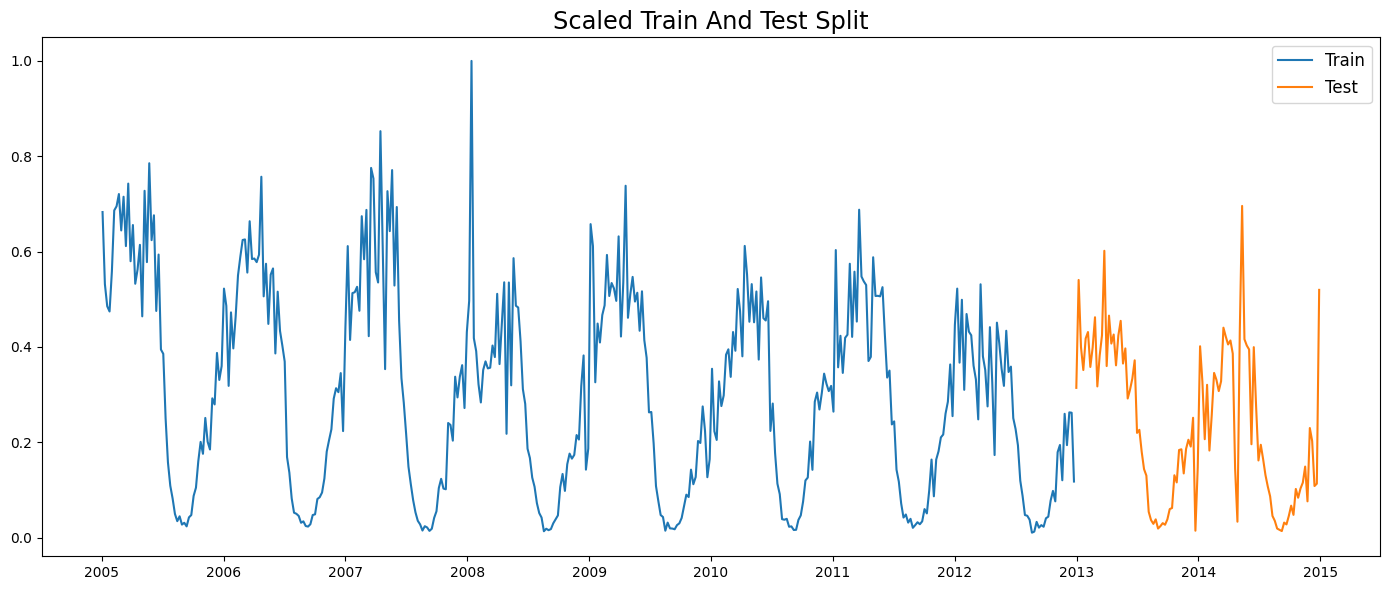

In [11]:
# Plot splitted scaled data
#fig1, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
#ax.plot(train_scaled, label='Train')
#ax.plot(test_scaled, label='Test')
#ax.legend(fontsize='large')
#ax.set_title('Scaled Train And Test Split', fontsize='xx-large')
#plt.show()

In [27]:
# Create data for RNN
def create_X_y(tseries: np.ndarray, lookback: int = LOOKBACK):
    result_x = []
    result_y = []
    for i in range(len(tseries) - lookback):
        result_x.append(np.reshape(tseries[i: i + lookback], (lookback, -1)))
        result_y.append(tseries[i + lookback])
    return np.array(result_x), np.array(result_y)

In [30]:
X, y = create_X_y(total_ts.values)
print(f'{X.shape = }\n{y.shape = }')

X.shape = (512, 10, 1)
y.shape = (512,)


## Model

In [ ]:
model = Sequential()

model.add(
    layers.SimpleRNN(
        units=LOOKBACK,
        activation = "tanh",
        return_sequences = True,
        input_shape = (LOOKBACK, 1)
    )
)